#Chest X-ray

Za izradu projekta korišćen je skup crno-belih rendgenskih snimaka grudnog koša sa kaggle sajta ([link ka skupu](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia)).

Slike su već skinute i mogu se naći na Google drajvu na [ovoj adresi](https://drive.google.com/drive/folders/11dYMiRJGWQBm9R-RhRcIsXQHhXNQNavH?usp=drive_link).

Iz Notebooka podacima se pristupa preko mountovane adrese `/content/drive/MyDrive/MasinskoUcenjeChestXRay/resources/raw`.

In [ ]:
import os

In [ ]:
images_root_path = "/content/drive/MyDrive/MasinskoUcenjeChestXRay/resources/raw"

def get_images(directory: str):
    for root, _, files in os.walk(directory):
      for file in files:
          yield os.path.relpath(
              os.path.join(root, file),
              start = directory
          )

all_images = [*get_images(images_root_path)]

In [ ]:
all_train = [*filter(lambda path: path.startswith("train/"), all_images)]
normal_train = [*filter(lambda path: "NORMAL" in path, all_train)]
pneumonia_train = [*filter(lambda path: "PNEUMONIA" in path, all_train)]

all_test = [*filter(lambda path: path.startswith("test/"), all_images)]
normal_test = [*filter(lambda path: "NORMAL" in path, all_test)]
pneumonia_test = [*filter(lambda path: "PNEUMONIA" in path, all_test)]

all_val = [*filter(lambda path: path.startswith("val/"), all_images)]
normal_val = [*filter(lambda path: "NORMAL" in path, all_val)]
pneumonia_val = [*filter(lambda path: "PNEUMONIA" in path, all_val)]


In [ ]:
print(f"Broj slika: {len(all_images)}")

def statistika_o_podacima(vrsta, zdravi, bolesni, ukupno, ceo_skup):
  print(
      f"Predefinisan broj {vrsta} instanci: {len(ukupno)}",
      f"\t- zdravi: {len(zdravi)}",
      f"\t- bolesni: {len(bolesni)}",
      f"\t- procenat u odnosu na ceo skup: {len(ukupno)/len(ceo_skup)*100:.1f}%",
      sep="\n"
  )

statistika_o_podacima("trening", normal_train, pneumonia_train, all_train, all_images)
statistika_o_podacima("test", normal_test, pneumonia_test, all_test, all_images)
statistika_o_podacima("validacionih", normal_val, pneumonia_val, all_val, all_images)

Broj slika: 5856
Predefinisan broj trening instanci: 5216
	- zdravi: 1341
	- bolesni: 3875
	- procenat u odnosu na ceo skup: 89.1%
Predefinisan broj test instanci: 624
	- zdravi: 234
	- bolesni: 390
	- procenat u odnosu na ceo skup: 10.7%
Predefinisan broj validacionih instanci: 16
	- zdravi: 8
	- bolesni: 8
	- procenat u odnosu na ceo skup: 0.3%


Najlogičnije u ovom slučaju je gledati odziv pozitivnih vrednosti (pošto je opasno reći bolesnom čoveku da je zdrav i poslati ga kući) u razumnim okvirima (savršen odziv bi bio kad bi za svakoga rekao da je bolestan). Podataka o bolesnim ljudima ima mnogo više. što ima smisla pošto kod lekara uglavnom idu ljudi koji se osećaju bolesno. U normalnim okolnostima bi trebala da se stavlja veća težina na bitnije, ali pošto ovde ima drastično više pozitivnih instanci to neću raditi pošto će modeli svakako biti naklonjeniji tome da daju pozitivno predviđanje, a razlika nije toliko drastična da će značajno poremetiti učenje modela.

Validacioni skup je previše mali da bi bio uportebljiv. U svrhe projekta spojiću ga sa trening skupom pa ću validacioni skup izdvajati iz trening skupa podataka.

Trening skup od 10% deluje u redu. Da bih mogao da uporedim svoje rezultate sa rezultatima drugih ljudi na sajtu test skup neću menjati.

In [ ]:
all_train += all_val

In [ ]:
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
from random import sample

In [ ]:
def get_sample(images, k, root):
  images = sample(images, k)
  images = map(lambda path: os.path.join(root, path), images)
  images = map(Image.open, images)
  return [*images]

sample_train = get_sample(all_train, 3, images_root_path)
sample_test = get_sample(all_test, 3, images_root_path)
sample_all = sample_train + sample_test

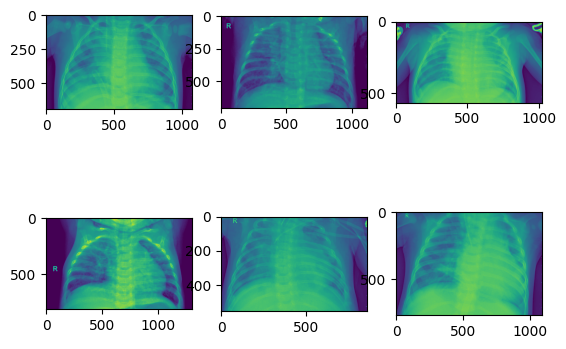

In [ ]:
w=2
h=3
fig=plt.figure()
for i, image in enumerate(sample_all):
    img = np.asarray(image)
    fig.add_subplot(w,h,i+1)
    plt.imshow(img)
plt.show()

Slike su različitih dimenzija, treba videti koji je raspon širina i visina. U ove svrhe koristiću samo trening skup da ne bi test skup uticao na odluke o pretprocesiranju.

In [ ]:
image_sizes = map(lambda path: os.path.join(images_root_path, path), all_train)
image_sizes = map(lambda path: Image.open(path).size, image_sizes)
image_sizes = [*image_sizes]

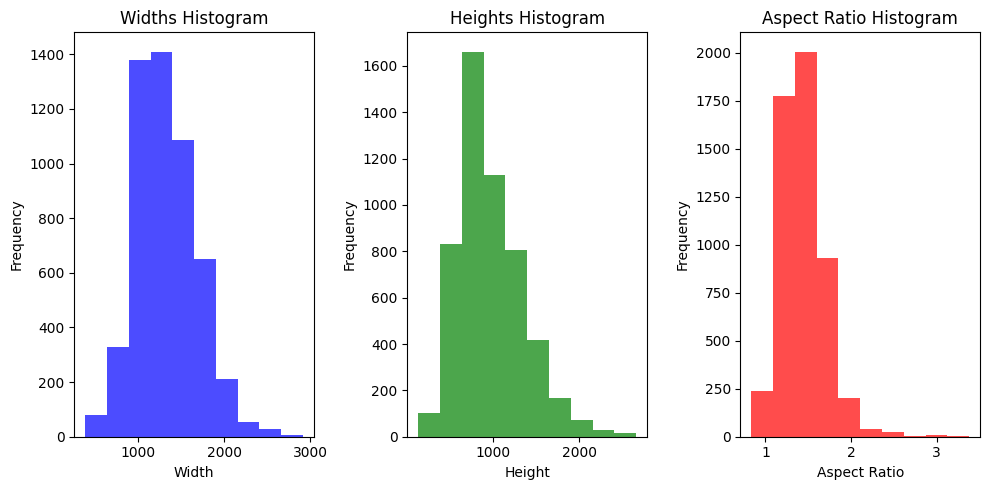

In [ ]:
widths = [pair[0] for pair in image_sizes]
heights = [pair[1] for pair in image_sizes]
aspect_ratios = [width / height for width, height in image_sizes]

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.hist(widths, bins=10, color='blue', alpha=0.7)
plt.title('Widths Histogram')
plt.xlabel('Width')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.hist(heights, bins=10, color='green', alpha=0.7)
plt.title('Heights Histogram')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.hist(aspect_ratios, bins=10, color='red', alpha=0.7)
plt.title('Aspect Ratio Histogram')
plt.xlabel('Aspect Ratio')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

In [ ]:
quantiles = [0, 5, 10, 25, 50, 75, 90, 100]

width_quantiles = np.percentile(widths, quantiles)
height_quantiles = np.percentile(heights, quantiles)
aspect_ratio_quantiles = np.percentile(aspect_ratios, quantiles)


quantiles_df = pd.DataFrame({
    'Quantile': quantiles,
    'Widths': width_quantiles,
    'Heights': height_quantiles,
    'Aspect Ratios': aspect_ratio_quantiles
})

quantiles_df.set_index('Quantile', inplace=True)

print(quantiles_df)

          Widths  Heights  Aspect Ratios
Quantile                                
0          384.0   127.00       0.835391
5          840.0   505.65       1.097086
10         920.0   568.00       1.149209
25        1056.0   688.00       1.257206
50        1284.0   888.00       1.411426
75        1552.0  1187.75       1.583333
90        1790.0  1479.60       1.750000
100       2916.0  2663.00       3.378788


In [ ]:
average_aspect_ratio = np.mean(aspect_ratios)
std_dev_aspect_ratio = np.std(aspect_ratios)

print("Average Aspect Ratio:", average_aspect_ratio)
print("Standard Deviation of Aspect Ratio:", std_dev_aspect_ratio)

Average Aspect Ratio: 1.4400470902389846
Standard Deviation of Aspect Ratio: 0.2570908200477473


Treba standardizovati veličinu slika da bi mogao da se trenira model. Zbog manjka domenskog znanja ne znam da li je u redu vršiti smicanje nad slikama (razvuči ih u širinu ili visinu) jer su možda proporcije na slikama veoma bitne.

Usled toga, odlučio sam da slike svedem na veličinu tako da što manji broj njih zapravo uvećavam a da odnosi ostanu koliko-toliko približni. Umesto smicanja slikama ću dati crni okvir (ako su preširoke imaće crno na vrhu i dnu, ako su predugačke imaće crno sa strane).

Da bi svi modeli koristili iste podatke (i da bih uštedeo vreme i samo jednom pretprocesirao slike) sve slike biće na putanji `/content/drive/MyDrive/MasinskoUcenjeChestXRay/resources/scaled`. Slike će biti dimenzija 400x280 što predstavlja približno prosečne proporcije.

Test skup neće biti korišćen do samog kraja, da bi se dobila verna ocena performansi

In [ ]:
images_scaled_path = "/content/drive/MyDrive/MasinskoUcenjeChestXRay/resources/scaled"
new_size = (400, 280)

In [ ]:
def normalize_image(old_image: Image, new_shape: tuple[int, int]) -> Image:
    prop = old_image.width / old_image.height
    if prop < new_shape[0]/new_shape[1]:
        #slika je malo visa i levo-desno treba dodati crno
        resized_im = old_image.resize((int(new_shape[1]*prop), new_shape[1]))
    else:
        #slika je malo sira i gore-dole treba dodati crno
        resized_im = old_image.resize((new_shape[0], int(new_shape[0]/prop)))
    new_im = Image.new("L", new_shape)
    new_im.paste(resized_im, ((new_shape[0]-resized_im.size[0])//2, (new_shape[1]-resized_im.size[1])//2))
    return new_im

def normalize_directory(src_files: list[str], dest_dir: str, new_shape: tuple[int, int] = new_size) -> None:
    if not os.path.isdir(dest_dir):
        os.makedirs(dest_dir)
    for img_name in src_files:
        src_img = Image.open(img_name)
        dest_img = normalize_image(src_img, new_shape)
        dest_img.save(os.path.join(dest_dir, os.path.split(img_name)[-1]))

In [ ]:
normalize_directory(
    map(lambda path: os.path.join(images_root_path, path), normal_test),
    os.path.join(images_scaled_path, "test", "NORMAL")
)

normalize_directory(
    map(lambda path: os.path.join(images_root_path, path), pneumonia_test),
    os.path.join(images_scaled_path, "test", "PNEUMONIA")
)

normalize_directory(
    map(lambda path: os.path.join(images_root_path, path), normal_train),
    os.path.join(images_scaled_path, "train", "NORMAL")
)

normalize_directory(
    map(lambda path: os.path.join(images_root_path, path), pneumonia_train),
    os.path.join(images_scaled_path, "train", "PNEUMONIA")
)

In [ ]:
all_scaled_images = [*get_images(images_scaled_path)]
all_scaled_train = [*filter(lambda path: path.startswith("train/"), all_scaled_images)]
all_scaled_test = [*filter(lambda path: path.startswith("test/"), all_scaled_images)]

sample_scaled_train = get_sample(all_scaled_train, 3, images_scaled_path)
sample_scaled_test = get_sample(all_scaled_test, 3, images_scaled_path)
sample_scaled_all = sample_scaled_train + sample_scaled_test

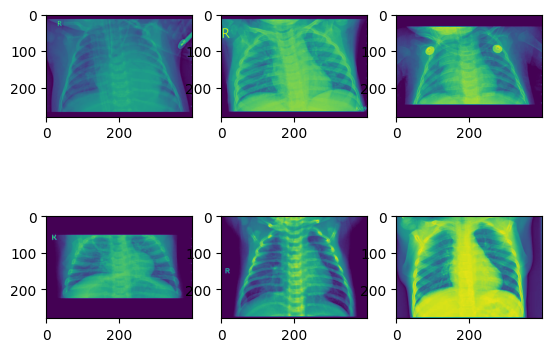

In [ ]:
w=2
h=3
fig=plt.figure()
for i, image in enumerate(sample_scaled_all):
    img = np.asarray(image)
    fig.add_subplot(w,h,i+1)
    plt.imshow(img)
plt.show()